# Deep Convolution Generative Advarsarial Network

Here is presented the implementation of the following parper https://arxiv.org/abs/1511.06434

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 11/02/2018


In [1]:
##### imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data mnist

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


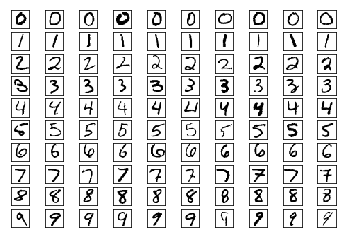

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data",one_hot=True)


#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(ut.max_row_index(mnist.test.labels)==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)

### Code parameters

For the architecture of the generator and the discriminator i am gonna try keep loyal to the network on the paper.



In [3]:
z_dimention = 100
mnist_flat_size = 784

batch_size = 64
epoach = 10000

### Generator network

* 2 Deconvolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Relu and tanh for output 

Note: I want that my final image have dimention $28 = 7\times2\times2$, so i can start with 7x7 image and upscale it by deconvolutions operations (with stride 2x2 and padding the image with zeros) the result would be a image with 14x14 and doing the same upscaling i get the final image with the size 28x28 (same as mnist :D)

In [4]:


Z = tf.placeholder(tf.float32, shape=[None, z_dimention], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='label_oneHot')
isTraining = tf.placeholder_with_default(False, shape=(), name='trainingPhase')

def generator(x,y,train,name):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :param train: boolean tensor with indication if we are training or not
    :return: tensor with shape (M,28,28,1) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.variable_scope("generator",reuse=tf.AUTO_REUSE):
        
        #ONLY diference between not conditinal DCGAN
        concat_input = tf.concat([x, y], 1)
        
        # 1 fully connected layer to get 7x7x64 output (3136)
        fc1 = tf.layers.dense(concat_input, 7*7*64,name="fc1_"+name)
        fc1_bn = tf.layers.batch_normalization(fc1, training=train, name="fc1_bn_"+name)
        fc_relu1 = tf.nn.relu(fc1_bn,name="fc1_fn_"+name)
        
        #reshape
        r = tf.reshape(fc_relu1, [-1, 7, 7, 64])
        
        # 1 deconv 64 filters output 14x14x32
        deconv1 = tf.layers.conv2d_transpose(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="dconv1_"+name)
        deconv1_bn = tf.layers.batch_normalization(deconv1, training=train,name="dconv1_bn_"+name)
        dc_relu2 = tf.nn.relu(deconv1_bn,name="dconv1_fn_"+name)

        # 2 deconv 1 filters and output 28x28x1
        deconv2 = tf.layers.conv2d_transpose(dc_relu2, 1, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="dconv2_"+name, activation=tf.nn.tanh)

        return deconv2



### Discriminator Network

* 2 Deconvolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Leaky relu (alpha 0.2 tensorflow default)

Kernel and stride size are the same as the generator

In [5]:

X = tf.placeholder(tf.float32, shape=[None, mnist_flat_size], name='x_discriminator_input')

def discriminator(x,y,train,name,drop_rate=0.5):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.variable_scope("discriminator",reuse=tf.AUTO_REUSE):
        
        #reshape
        r = tf.reshape(x, [-1, 28, 28, 1])
        yr = tf.reshape(y, [-1, 1, 1, y.shape[-1]])
        
        # 1 conv 64 filters output 14x14x32
        conv1 = tf.layers.conv2d(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="conv1_"+name)
        conv1_bn = tf.layers.batch_normalization(conv1, training=train, name="conv1_bn_"+name)
        c_lrelu1 = tf.nn.leaky_relu(conv1_bn,name="conv1_fn_"+name)
        
        c_lrelu1_concat_y = tf.concat([c_lrelu1, tf.tile(yr,
        [1, tf.shape(c_lrelu1)[1], tf.shape(c_lrelu1)[2], 1])], axis=3)
        
        # 2 conv 32 filters and output 7x7x32
        conv2 = tf.layers.conv2d(c_lrelu1_concat_y, 32, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="conv2_"+name)
        conv2_bn = tf.layers.batch_normalization(conv2, training=train, name="conv2_bn_"+name)
        c_lrelu2 = tf.nn.leaky_relu(conv2_bn, name="conv2_fn_"+name)
        
        #flatten
        flatten = tf.layers.flatten(c_lrelu2)
        
        fc1 = tf.layers.dense(flatten, 7*7*32,name="fc1_"+name,activation=tf.nn.leaky_relu)
        fc1_drop = tf.layers.dropout(fc1,rate = drop_rate, training=train)
        
        fc2 = tf.layers.dense(fc1_drop, 256,name="fc2_"+name,activation=tf.nn.leaky_relu)
        fc2_drop = tf.layers.dropout(fc2,rate = drop_rate, training=train)
        
        fc3 = tf.layers.dense(fc2_drop, 1,name="fc3_"+name, activation=None)
        
        sig_fc3 = tf.nn.sigmoid(fc3)
        
        return sig_fc3,fc3

    

### Loss functions

In [6]:
#using now the xentropy (TODO use the default)
generated_sample = generator(Z,Y,isTraining,"g_")
d_fake_prob, d_fake_logits = discriminator(generated_sample,Y,isTraining,"d_")

#normalize between -1 1, perhaps more effecient to cache the results or pre process
X_tanh_normalize = (X-0.5)*2
d_true_prob, d_true_logits = discriminator(X_tanh_normalize,Y,isTraining,"d_")

alternative_loss = True

print(d_true_logits)
print(d_fake_logits)
print(generated_sample)
#try avoid log(0)
eps = 1e-8

def xentropy_sigmoid(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

with tf.name_scope("discriminator_loss"):
    if alternative_loss:
        d_loss = xentropy_sigmoid(d_true_logits,tf.ones_like(d_true_logits)) + xentropy_sigmoid(d_fake_logits,tf.zeros_like(d_fake_logits)) 
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob + eps) + tf.log(1. - d_fake_prob + eps))


with tf.name_scope("generator_loss"):
    if alternative_loss:
        g_loss = xentropy_sigmoid(d_fake_logits, tf.ones_like(d_fake_logits))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob + eps))
    
    

Tensor("discriminator_1/fc3_d_/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator/fc3_d_/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("generator/dconv2_g_/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [7]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'generator/fc1_g_/kernel:0' shape=(110, 3136) dtype=float32_ref>, <tf.Variable 'generator/fc1_g_/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/gamma:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/beta:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/kernel:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'discriminator/conv1_d_/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_d_/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_bn_d_/gamma:0' shape=(64

### Train

Epoach 0
Discriminator loss:  1.82761
Generator loss: 0.755013


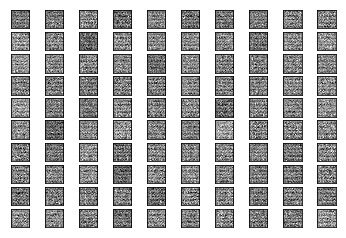

Epoach 500
Discriminator loss:  0.55641
Generator loss: 1.94165


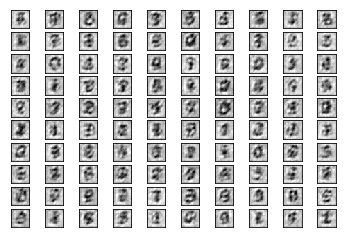

KeyboardInterrupt: 

In [8]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4,beta1=0.1)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing the loss, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4,beta1=0.3)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


## Start graph computations and algorithm

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train ,Y:y_train , Z: ut.random_Z(batch_size,n=z_dimention), isTraining:True})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Y: y_train, Z: ut.random_Z(batch_size,n=z_dimention), isTraining:True})

    if i%500 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        
        z_new = ut.random_Z(images_per_class*10,n=z_dimention)
                
        conditional_y = ut.one_hot(np.repeat(list(range(10)), images_per_class))
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y}).reshape((images_per_class*10,784))
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)

### Testing the classifier

In [ ]:
sess.close()